## Apply a Voronoi cells subdivision to the Vigilo observations of Brest

In [2]:
# Import necessary packages
import datetime  # For handling dates and times
import locale    # For setting the locale
import textwrap  # For wrapping text
import requests  # For making HTTP requests
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For improving the visual appearance of plots
import overpy  # For accessing OpenStreetMap data
import geopy.distance  # For calculating distances between two points
from scipy.spatial import Voronoi, voronoi_plot_2d  # For creating Voronoi diagrams
import numpy as np  # For numerical operations
import scipy.spatial as spatial  # For spatial operations
import matplotlib.path as path  # For creating paths in Matplotlib
import matplotlib as mpl  # For configuring Matplotlib
import smopy  # For dealing with OpenStreetMap tiles
import random  # For generating random numbers
import matplotlib.patches as patches  # For creating patches in Matplotlib
import warnings # For disabling future warnings



# Set the French locale for formatting dates
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

# Set the seaborn style for better visual appearance of plots
sns.set_style("darkgrid")

# Set the seaborn context with a larger font size
sns.set_context("talk", font_scale=0.8)

# Define colors to be used in plots
blue, orange = sns.color_palette("muted", 2)

Lowered zoom level to keep map size reasonable. (z = 13)


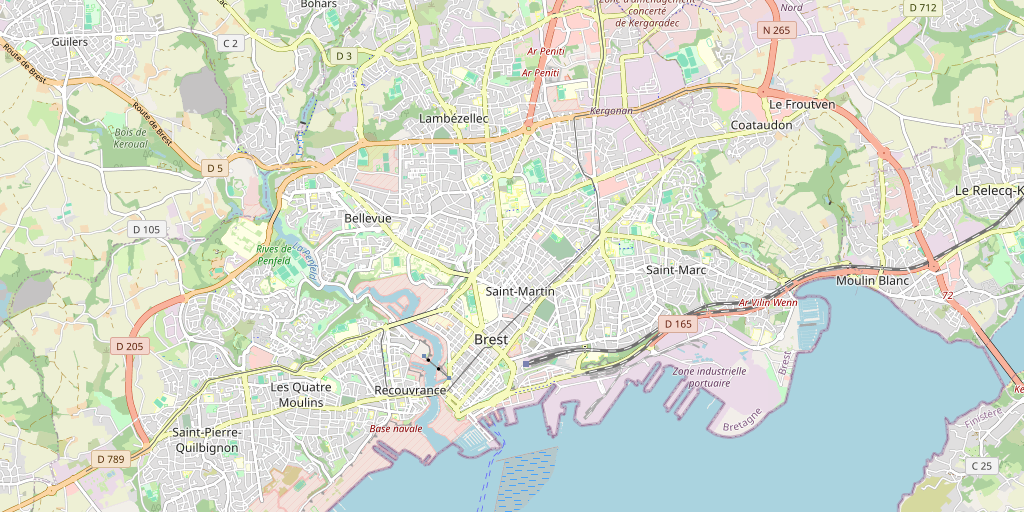

In [3]:
# Get and parse the data

# Suppressing the FutureWarning related to is_categorical_dtype
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Make an HTTP GET request to fetch data from a specified URL
    resp = requests.get('https://vigilo.bapav.org/get_issues.php') # vigilo database of BaPaV
    
    # Convert the JSON response to a DataFrame
    df = pd.DataFrame(resp.json())
    
    # Filter out rows where the 'comment' column is empty
    df = df[df.comment != '']
    
    # Convert the 'time' column to datetime format, assuming it's in seconds since epoch
    df.time = pd.to_datetime(df.time, unit='s')
    
    # Add a new column 'julian_day' representing the day of the year
    df['julian_day'] = df.time.apply(lambda x: x.timetuple().tm_yday)
    
    # Filter out data before January 1, 2020
    df = df[df.time.apply(lambda x: x.year) > 2019]
    
    # Sort the DataFrame by the 'time' column in ascending order
    df = df.sort_values(by='time', ascending=True)
    
    # Reset the index after sorting
    df = df.reset_index(drop=True)
    
    # Define a bounding box for the map around Brest
    box = (48.377, -4.556,
           48.416, -4.441)
    
    # Create a map using OpenStreetMap tiles within the specified bounding box at zoom level 20
    m = smopy.Map(box, z=20)
    
    # Show the map in the IPython environment
    m.show_ipython()

In [4]:
import numpy as np

def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    
    Parameters:
    - vor: scipy.spatial.Voronoi object
           Voronoi diagram computed using the scipy library.
    - radius: float, optional
              Radius of the bounding circle around the original points.
              If not provided, it is set to the maximum point-to-point
              distance in the Voronoi diagram.
              
    Returns:
    - new_regions: list
                   List of finite polygons representing Voronoi regions.
    - new_vertices: numpy array
                    Array containing the coordinates of the new vertices
                    added during reconstruction.
    
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    
    new_regions = []  # List to store finite polygons
    new_vertices = vor.vertices.tolist()  # List to store new vertices
    
    center = vor.points.mean(axis=0)  # Compute the center of the points
    
    # If radius is not provided, set it to the maximum point-to-point distance
    if radius is None:
        radius = vor.points.ptp().max()
    
    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        
        if all(v >= 0 for v in vertices):
            # Finite region: already in the new_regions list
            new_regions.append(vertices)
            continue
        
        # Reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # Finite ridge: already in the region
                continue
            
            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1]  # Tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # Normal
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        
        # Sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())
    
    return new_regions, np.asarray(new_vertices)

In [5]:
# Initialize an empty list to store coordinate tuples
coos = []

# Iterate over the rows of the DataFrame to extract coordinates
for i in range(len(df.coordinates_lon)):
    # Extract latitude and longitude values from the DataFrame
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])

    # Append the coordinate tuple (latitude, longitude) to the list
    coos.append((x, y))

In [6]:
# Compute the Voronoi diagram for the given coordinates
vor = spatial.Voronoi(coos)

# Reconstruct finite polygons from infinite Voronoi regions
regions, vertices = voronoi_finite_polygons_2d(vor)

# Convert the vertices of Voronoi regions to pixel coordinates on the map
cells = [m.to_pixels(vertices[region]) for region in regions]

/home/chenry01/.local/lib/python3.10/site-packages/smopy.py:140: RuntimeWarning: invalid value encountered in log
  ytile = f((1.0 - np.log(np.tan(lat_rad) + (1 / np.cos(lat_rad))) / np.pi) /


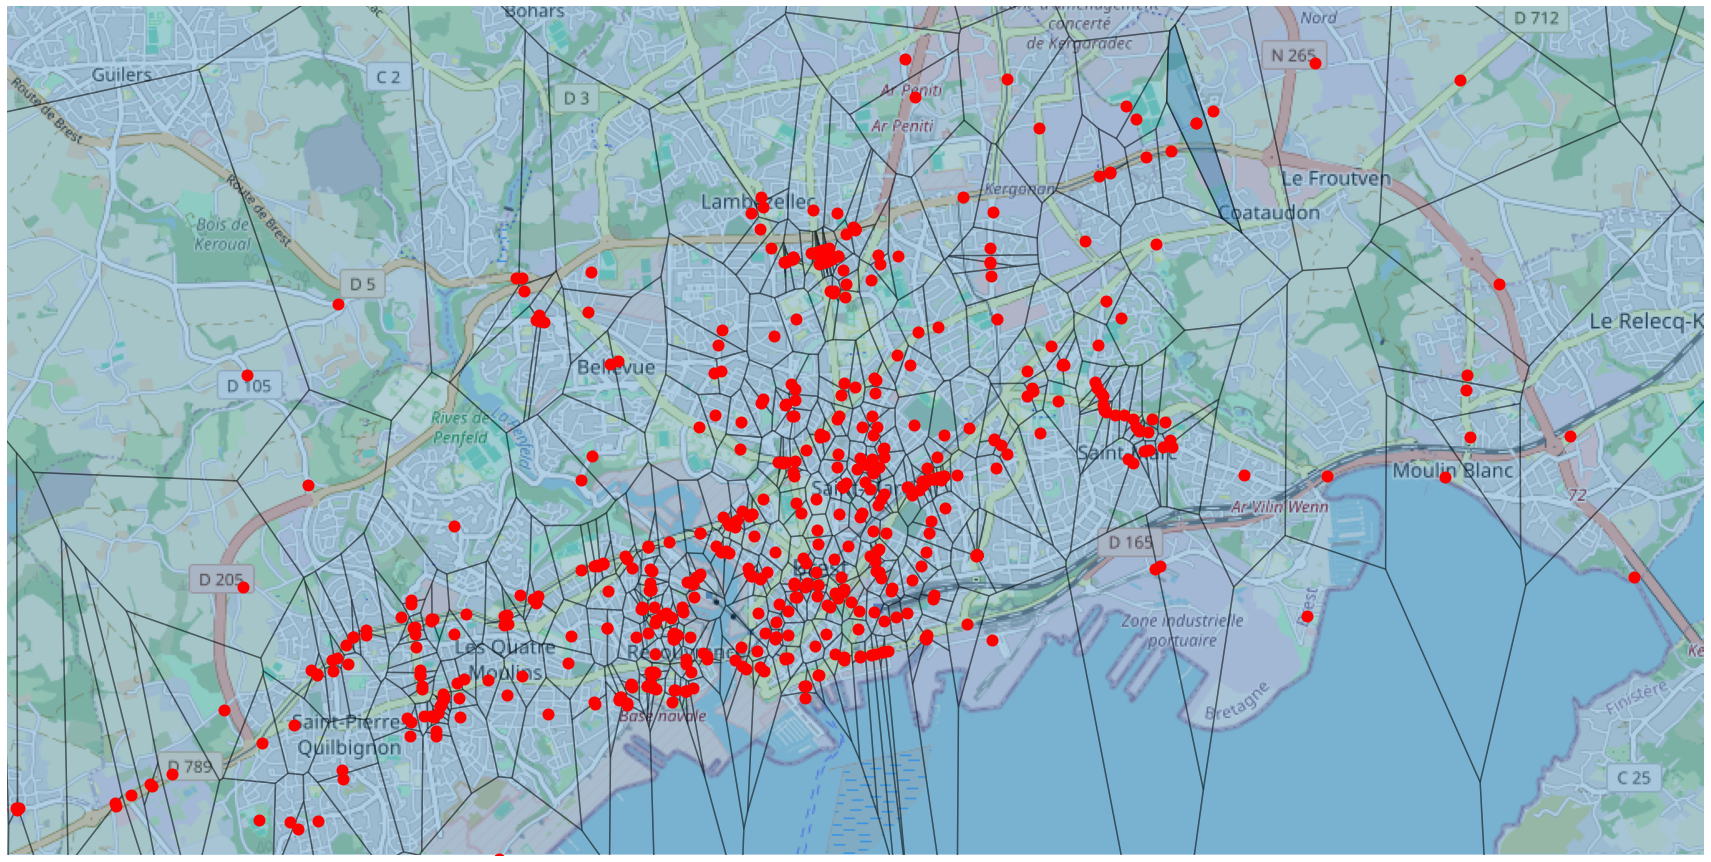

In [7]:
# Show the map using Matplotlib with a specified figure size
ax = m.show_mpl(figsize=(24, 16))

# Add a PolyCollection to the map representing the Voronoi cells
ax.add_collection(
    mpl.collections.PolyCollection(
        cells,              # List of polygons representing Voronoi cells
        edgecolors='k',     # Edge color of the polygons
        alpha=0.35          # Transparency level of the polygons
    )
)

# Plot individual points on the map
for i in range(len(df.coordinates_lon)):
    # Extract latitude and longitude from the DataFrame
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])

    # Convert geographical coordinates to pixels on the map
    xp, yp = m.to_pixels(x, y)

    # Plot the points on the map as red circles
    ax.plot(xp, yp, 'or', ms=10, mew=2)